# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd
from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

tf.config.optimizer.set_jit(True)  #setting the XLA (Accelerated Linear Algebra) flag 

# # Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2023-12-21 17:14:34.411777: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 17:14:34.455584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 17:14:34.455619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 17:14:34.455625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 17:14:34.463833: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-12-21 17:14:37.164562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 17:14:37.211452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 17:14:37.211700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/ubuntu/Thesis/quijote/" # add path to the data directory

## Loading the Data
We are considering $k_{max} = 0.2$ "mildly linear" case. The data "df" contains the normalized parameters and summary statistics in one single data frame. The data "df_lbl" contains the normalised parameters. The summary statistics used here are power spectrum (P0_0 - P0_31),
marked power spectrum(MP0, MP01, MP02, MP04 each with 32 entries eg. MP0_0 - MP0_31), bispectrum(B_0 - B_72),marked bispectrum(MB, MB1, MB2, MB4 each with 67 entries from MB_0 -MB_66) and halo mass function(HMF_0-HMF_11). The labels contains the parameters $f_{NL}^{eq}$,$\Omega_m$,$h$,$n_s$,$\sigma_8$

In [4]:
# # Reading the data

# pk = pd.read_csv(directory_path+"Pk_lh.csv")[:80].T                      # taking transpose to keep in check the dimensionality
# pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
# params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

# #normalising the parameters
# mean_params = params.mean(axis=0).values
# std_params = params.std(axis = 0).values
# norm_params = (params - mean_params)/std_params

# # Concatenating the params and pk

#df = pd.concat([norm_params,pk],axis = 1)


# P_k = df[df.columns[5:]]
# van_labels = df[df.columns[:5]]


## Reading the Data
df_all = pd.read_csv(directory_path + "data_lh_0pt5.csv")

## Unnormalised parameters
df_lbl = pd.read_csv(directory_path + "unnormalised_lbl.csv")
mean_params = df_lbl.mean(axis=0).values # mean of params
std_params = df_lbl.std(axis = 0).values # standard deviation of params

df_all


,fnl_equil,Om,h,ns,s8,P0_0,P0_1,P0_2,P0_3,P0_4,...,HMF_2,HMF_3,HMF_4,HMF_5,HMF_6,HMF_7,HMF_8,HMF_9,HMF_10,HMF_11
0,0.579947,0.285646,-0.895023,0.628420,-0.770378,7.694324e+04,72699.988971,80060.577932,66006.190973,60844.371143,...,16901,9873,5786,3040,1506,618,221,67,11,3
1,-0.219861,-0.161000,-0.822313,-1.296658,1.237798,1.784552e+05,217724.754529,170829.183345,122275.653483,111882.779876,...,15712,10474,6948,4290,2654,1600,882,450,163,71
2,-1.185862,-1.317432,-0.901948,0.725367,-1.570185,1.272849e+06,877065.512870,691072.249241,417614.884669,360848.651773,...,2035,1041,499,215,70,23,9,0,0,0
3,-0.545323,0.302957,1.327819,-1.687906,1.248185,4.066970e+04,72895.619417,78330.482070,70627.845993,64061.072840,...,22477,14804,9930,6219,3777,2095,1088,509,209,58
4,1.660207,1.680981,-1.109690,1.680981,0.077903,1.245194e+04,18920.361863,22937.191376,27123.116865,24749.233084,...,39873,26164,16630,9836,5274,2730,1176,408,133,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.632508,-1.435153,0.818851,0.929647,0.870786,6.906393e+05,477106.546386,407935.986024,252411.271003,168527.313031,...,6247,3820,2194,1260,671,306,139,48,15,4
996,-1.590959,0.320269,-1.667132,0.199086,-1.428228,9.062285e+04,118855.924989,115250.670403,107756.660844,90393.284458,...,11838,6488,3456,1692,786,248,81,14,5,0
997,0.694205,0.940034,-0.264871,0.271796,-0.323732,2.706000e+04,35874.495733,42646.730659,42935.895217,38941.706934,...,26815,16834,10118,5692,3005,1414,569,191,50,12
998,0.507237,-0.635345,-1.206636,0.424140,-1.403991,3.310482e+05,330489.896973,242223.693255,216801.822755,162986.136645,...,6081,3249,1739,788,353,136,43,8,2,0


#### Creating different datasets for different summary statistics.

In [5]:
# PARMAETERS AND SUMMARY STATISTICS 
"""
sliced the main dataset into different statistics
"""
norm_lbl = df_all.loc[:,'fnl_equil':'s8']
P0  = df_all.loc[:,'P0_0':'P0_79']
MP0 = df_all.loc[:,'MP01_0':'MP04_79']
B0  = df_all.loc[:,'B_0':'B_72']
MB  = df_all.loc[:,'MB1_0':'MB4_66']
HMF = df_all.loc[:,'HMF_0':'HMF_11']
MP0_0 = df_all.loc[:,'MP0_0':'MP0_79']
MB0  = df_all.loc[:,'MB_0':'MB_66']


In [6]:
# Function to create input data fot combination of summary statistics

def input_data(columns,norm_lbl):
    
    """
    columns: it takes a list input of the summary statistics
    norm_lb: it is the normalised label of the parameters
    selects the different summary statistics 
    to make it into a single dataframe, which 
    can then be used as the input in the NN.
    """
    
    assert isinstance(columns, list), "Input is not a list"
    df_columns = pd.concat(columns,axis =1)
    
    return pd.concat([norm_lbl,df_columns],axis=1)


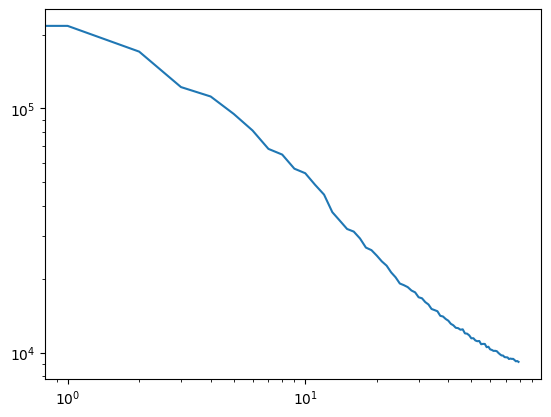

In [7]:
#Plotting the power spectrum
plt.plot(P0.T[1])             # Transposing to plot power spectrum for each simulation 
plt.loglog()
plt.show()


#### Data splitting into Train, Validation and Test set

In [8]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    
    """
    df: The input dataframe
    params: the number of params default set to 5. Change if adding more parameters
    train_frac: fraction of training data
    test_frac: fraction of test data
    """
    
    # Permuting the DataFrame to avoid any bias.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

# Define couple of useful functions

#### Defining the loss plot function

In [9]:
# Function defining loss plot.

def plot_loss(df_history, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(df_history.index, df_history['loss'], label='Training_loss')
    plt.plot(df_history.index, df_history['val_loss'], label='Validation_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

#### LaTex Label Names

In [10]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

label_LaTeX_names_equilateral = [r"$f_{NL}^{eq}$", 
                                 r"$\Omega_m$",
                                 r"$h$",
                                 r"$n_s$",
                                 r"$\sigma_8$"]

#### Defining Elu+1 activation function
Used for positive definiteness of the Sigma outputs. ELU gives a negative output however for the sigma values we need a positive definiteness so ELU+1 helps with that

In [11]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

# Analysis

## Building the model
Creating layers and defining hyperparameter tuninig. Also defined ELU+1 activation funtion

In [12]:
# #############################   Creating Layers  #############################
# def create_layers(architecture, dropout_rate,X_training_set):  
#     # The features are normalized to have mean=0 and std=1
#     inputs = Input(shape= X_training_set.shape[1])
#     normalize_layer = layers.Normalization()
#     normalize_layer.adapt(X_training_set)
#     norm_inputs = normalize_layer(inputs)
#     input_layer = norm_inputs

    
#     # Adding hidden dense layers which is specified by the architecture in our case it is 3 layers with 32 neurons each




    
#     for n_nodes in architecture:
#         d_layer = layers.Dense(n_nodes,
#                               activation="selu",
#                               kernel_initializer="he_normal",)(input_layer)

        
#     # Each is followed by a dropout layer  to apply dropout regularisation to the o/p of the d_layer which is then assigned to the input_layer for the next iteration which is the two dense layer mean and sigma our output layers
        
        
#         input_layer = layers.Dropout(dropout_rate)(d_layer)


#     # Add the output layer combining means and sigmas
   
    
#     means = layers.Dense(
#         5,
#         activation="linear",
#         kernel_initializer="he_normal",
#     )(input_layer)

#     sigmas = layers.Dense(
#         5, 
#         activation="elu_plus_one",
#     )(input_layer)

#     output_layer = layers.Concatenate()([means, sigmas])
    
#     return inputs, output_layer


In [13]:
# def hp_model_for_dataset():
#     class MyHyperModel(kt.HyperModel):
#         def build(self,hp):

    
# #############################   Hyper-tuning Parameters  #############################  
#             num_layers = hp.Int('num_layers', min_value=1, max_value=5)
            
#             architecture = [hp.Int(f"unit_num_{i}", min_value = 32,
#                                    max_value = 512, step = 32) for i in range(num_layers)]
            
#             # hp_base_lr = hp.Float('base_lr', min_value=1e-6, max_value=1e-2, sampling='log')
#             # opt_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) #optimizer learning rate
            
#             dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
            
        
        
#         #############################   Creating Model  #############################
            
#             inputs, output_layer = create_layers(architecture, dropout_rate,X_training_set)
#             model = Model(inputs=inputs, outputs=output_layer)
            
            
#             model.compile(
#                 loss=mse_means_and_sigmas_uncorrelated,
#                 # optimizer=tf.optimizers.Adam(learning_rate=opt_learning_rate),
#                 optimizer=tf.optimizers.Adam(learning_rate=1.e-3),
#             )
#             model.summary()
            
#             return model
#         def fit(self, hp, model, *args, callbacks=[], **kwargs):
#             hp_base_learning_rate = hp.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")
#             print(hp_base_learning_rate)

#             clr_triangular = CLR.CyclicLR(#mode='exp_range',
#                                       base_lr=hp_base_learning_rate,
#                                       max_lr=hp_base_learning_rate*4.,
#                                       step_size=3*4, # recommended (2-8) x (training iterations in epoch)
#                                       gamma=0.99994)

#             return  model.fit(
#                 *args,
#                 callbacks=callbacks+[clr_triangular],
#                  **kwargs
#             )
#     return MyHyperModel()



In [14]:
def hp_model_for_dataset():
    class MyHyperModel(kt.HyperModel):
        def build(self, hp):
            #############################   Hyper-tuning Parameters  #############################
            num_layers = hp.Int('num_layers', min_value=1, max_value=8) #3
            architecture = [hp.Int(f"unit_num_{i}", min_value=32, max_value=1024, step=32) for i in range(num_layers)]  #[384, 96, 256]
            dropout_rate =  hp.Float('dropout_rate',min_value= 0.1, max_value= 0.5, sampling="log") #0.10320930206682662
            opt_learning_rate = hp.Float('learning_rate',min_value= 1e-5, max_value= 1e-2, sampling="log") #optimizer learning rate 0.00030932800521408247 #
           


            #############################   Creating Layers  #############################

            # The features are normalized to have mean=0 and std=1
            inputs = Input(shape=X_training_set.shape[1])
            normalize_layer = layers.Normalization()
            normalize_layer.adapt(X_training_set)
            norm_inputs = normalize_layer(inputs)
            input_layer = norm_inputs

            # Adding hidden dense layers which is specified by the architecture
            for n_nodes in architecture:
                d_layer = layers.Dense(n_nodes, activation="selu", kernel_initializer="he_normal")(input_layer)

                # Each is followed by a dropout layer to apply dropout regularization
                input_layer = layers.Dropout(dropout_rate)(d_layer)

            # Add the output layer combining means and sigmas
            means = layers.Dense(5, activation="linear", kernel_initializer="he_normal")(input_layer)
            sigmas = layers.Dense(5, activation="elu_plus_one")(input_layer)
            output_layer = layers.Concatenate()([means, sigmas])

            #############################   Creating Model  #############################

            model = Model(inputs=inputs, outputs=output_layer)

            model.compile(
                loss=mse_means_and_sigmas_uncorrelated,
                optimizer=tf.optimizers.Adam(learning_rate= opt_learning_rate),
            )
            model.summary()

            return model

        def fit(self, hp, model, *args, callbacks=[], **kwargs):
            
            #############################   Hyper-tuning CLR and batch size #############################
           
            batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512])
           
            hp_base_learning_rate =  hp.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")#9.365959093508116e-05
            print("Cyclic lR:",hp_base_learning_rate)
            
            clr_triangular = CLR.CyclicLR(
                base_lr=hp_base_learning_rate,
                max_lr=hp_base_learning_rate * 4.,
                step_size=3 * 4,  # recommended (2-8) x (training iterations in epoch)
                gamma=0.99994)
            
            return model.fit(
                *args,
                callbacks=callbacks + [clr_triangular],
                batch_size=batch_size,
                **kwargs
            )

    return MyHyperModel()

        

## Defining loss

In [15]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    
    means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    y_true = tf.cast(y_true, dtype=y_pred.dtype) #????? 
    
    squared_differences = tf.math.square(y_true - means_pred)
    sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)

    return loss

## Define callbacks

In [16]:
# Definfing callbacks using cyclic learning rate in our case
# def callback(base_lr):
# max_lr = 1.e-3
# clr_triangular = CLR.CyclicLR(#mode='exp_range',base_lr=max_lr/4.,
#                               max_lr=max_lr,
#                               step_size=3*4, # recommended (2-8) x (training iterations in epoch)
#                               gamma=0.99994)

#                               # base_lr = base_lr, #hp_base_learning_rate, # max_lr/4.,
#                               # max_lr = base_lr*4,#hp_base_learning_rate*4.# max_lr,
#                               # step_size=3*4, # recommended (2-8) x (training iterations in epoch)
#                               # gamma=0.99994)
def callback_early_stopping():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
        restore_best_weights=True,
        verbose=0,
    )
    return [early_stopping]

## Define some ancillary stuff

In [17]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

In [18]:
# prediction of parameters
def prediction(model,X_test_set,y_test_set,mean_params,std_params,title):
    
    """
    model: model name of the fitting model
    X_test_set: Test set
    y_test_set: Test Label
    title: String i/p - summary statistics used
    """
    assert isinstance(title, str), "Title must be a string"
    predictions = model.predict(X_test_set, verbose=0)
    df_predictions = pd.DataFrame(predictions)
    y_mean_predict = df_predictions[df_predictions.columns[:5]]
    y_sigma_predict = df_predictions[df_predictions.columns[5:]]
    
    true_y = ((y_test_set * std_params) + mean_params).reset_index(drop=True).values
    predict_y = ((y_mean_predict * std_params)  + mean_params).values
    predict_E = (y_sigma_predict*std_params).values
    # print("Returns true_y, predict_y, predict_E, df_predictions")
    
    #Plot of Predicted, std_dev, Bias vs True 
    for j in range(len(mean_params)):
        check_predictions(
            true_y[:,j],
            predict_y[:,j],
            predict_E[:,j],
            label=label_LaTeX_names_equilateral[j],
            title= title)
    return (true_y,predict_y,predict_E,df_predictions)
    


In [19]:
# #Plot of Predicted, std_dev, Bias vs True 

# def param_plot(predictions,param_number = 5):
#     """
#     predictions: Calls the prediction function
#     """
#     for j in range(param_number):
#         check_predictions(
#             predictions[0][:,j],
#             predictions[1][:,j],
#             predictions[2][:,j],
#             label=label_LaTeX_names_equilateral[j],
#             title="P0")


# Tuning hyperparameters

### All summary statistic

In [20]:
#performing spitting
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_all,random_state = 1 )


In [36]:
X_training_set = X_train

# Instantiating the tuner
tuner = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='all_pt5_1_trial_update')
# Running the HyperParameter Search

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100000, callbacks=[early_stopping])





Trial 10 Complete [00h 01m 13s]
val_loss: -5.342004299163818

Best val_loss So Far: -5.957964897155762
Total elapsed time: 00h 12m 56s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
4                 |3                 |num_layers
352               |448               |unit_num_0
0.00097252        |0.00012836        |base_lr
0.1               |0.1               |dropout_rate
64                |448               |unit_num_1
32                |96                |unit_num_2
352               |None              |unit_num_3
160               |None              |unit_num_4

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 753)]                0         []                            
                                                                                

KeyboardInterrupt: 

#### Let us see the best hypertune parameters

In [45]:
print(tuner.search_space_summary())
print(tuner.results_summary())
# tuner.results_summary()

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'samplin

In [46]:
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp.get('num_layers')
best_architecture = [best_hp.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp.get('learning_rate')
best_dropout_rate = best_hp.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")



Best Hyperparameters:
- Number of Layers: 2
- Architecture: [512, 96]
- Learning Rate: 0.0001
- Dropout Rate: 0.1



In [47]:
# Fitting the model
model,normalize_layer = model_build(best_hp)
histories= model.fit(
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    batch_size=512,
    epochs=1000000,
    callbacks=[clr_triangular, early_stopping],
    verbose=1,
)
# Histories return 
df_history = pd.DataFrame(histories.history)
df_history

Epoch 1/1000000


2023-12-05 22:35:37.649047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2/2 [==============================] - 4s 2s/step - loss: 7.4715 - val_loss: 6.0226
Epoch 2/1000000
2/2 [==============================] - 0s 481ms/step - loss: 5.4051 - val_loss: 4.7066
Epoch 3/1000000
2/2 [==============================] - 0s 25ms/step - loss: 4.7701 - val_loss: 5.0977
Epoch 4/1000000
2/2 [==============================] - 0s 25ms/step - loss: 5.0089 - val_loss: 6.1640
Epoch 5/1000000
2/2 [==============================] - 0s 24ms/step - loss: 5.2660 - val_loss: 5.3013
Epoch 6/1000000
2/2 [==============================] - 0s 24ms/step - loss: 4.7731 - val_loss: 8.5472
Epoch 7/1000000
2/2 [==============================] - 0s 24ms/step - loss: 5.3878 - val_loss: 7.0686
Epoch 8/1000000
2/2 [==============================] - 0s 24ms/step - loss: 5.9191 - val_loss: 6.5503
Epoch 9/1000000
2/2 [==============================] - 0s 28ms/step - loss: 5.4376 - val_loss: 3.7647
Epoch 10/1000000
2/2 [==============================] - 0s 27ms/step - loss: 4.5202 - val_loss: 3.7

,loss,val_loss
0,7.471519,6.022574
1,5.405050,4.706612
2,4.770056,5.097726
3,5.008881,6.164019
4,5.265980,5.301318
...,...,...
1156,-4.093009,-4.459453
1157,-4.426356,-4.938330
1158,-4.671915,-5.162950
1159,-4.738367,-4.880514


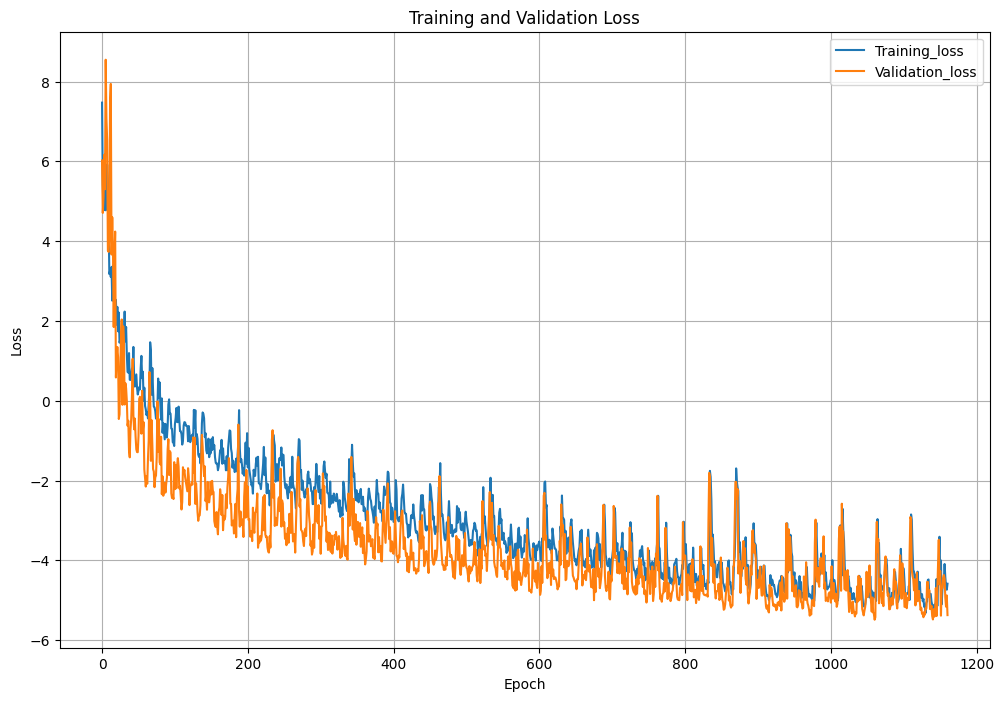

In [48]:
plot_loss(df_history)#, logy=True, ylim=[15, 25])

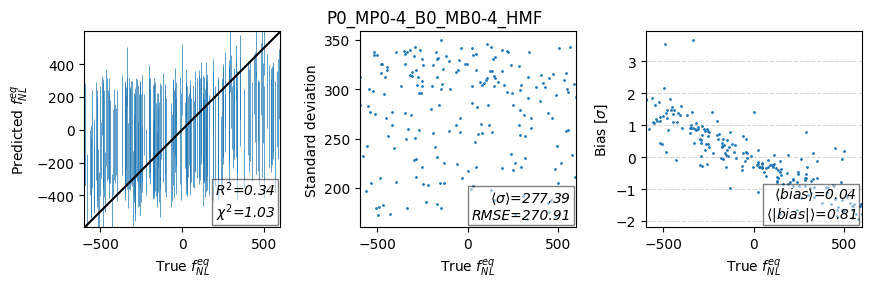

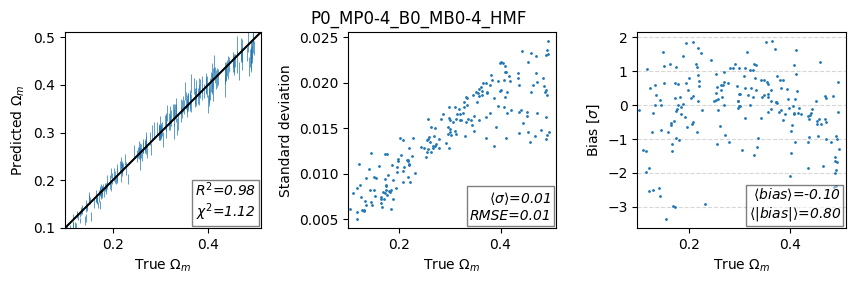

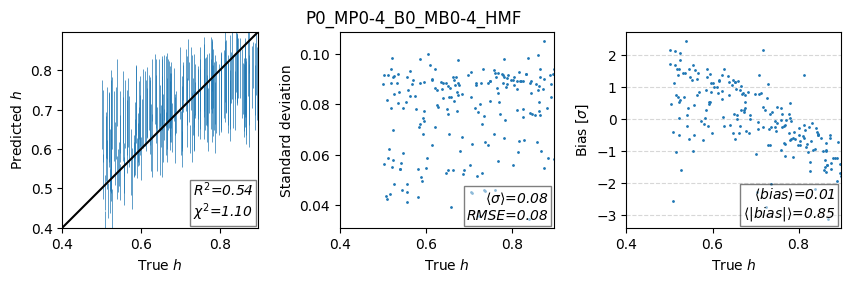

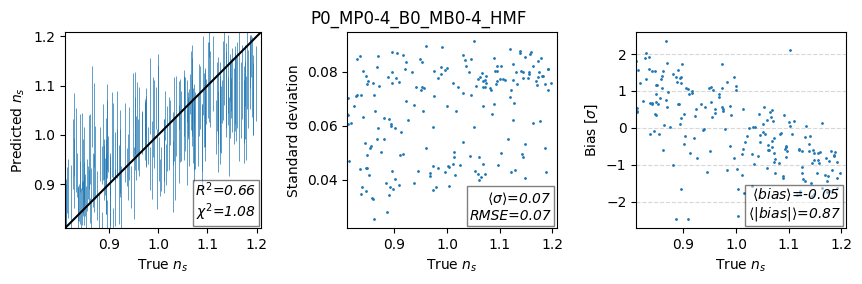

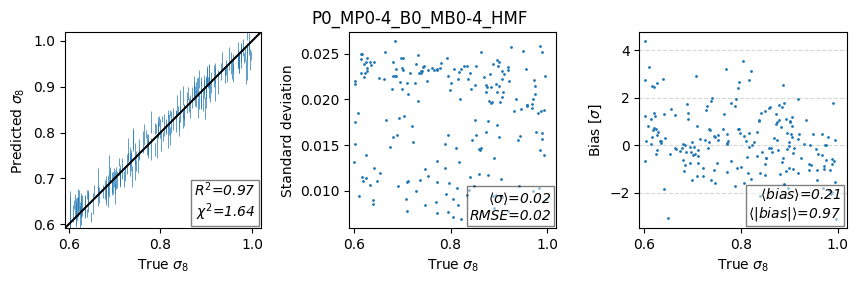

In [62]:
predictions = prediction(model,X_test,y_test,mean_params,std_params,title = "P0_MP0-4_B0_MB0-4_HMF")


#### Let us try a different set of summary statistics 

In [35]:
# Call the Data
columns = [P0, B0, HMF]
df_1 = input_data(columns,norm_lbl)


In [36]:
#Split 
X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = train_val_test_split(df_1, random_state = 3)
X1_test

,P0_0,P0_1,P0_2,P0_3,P0_4,P0_5,P0_6,P0_7,P0_8,P0_9,...,HMF_2,HMF_3,HMF_4,HMF_5,HMF_6,HMF_7,HMF_8,HMF_9,HMF_10,HMF_11
804,2.340585e+06,1.541554e+06,1.013401e+06,566312.685728,407066.069983,321104.725693,281989.259236,275458.593362,300327.774732,274540.552188,...,1681,890,447,206,73,28,14,2,0,0
551,6.266669e+05,4.977549e+05,3.950592e+05,293484.792586,214386.344454,180716.130561,144061.176249,149227.856372,134663.398707,117302.143610,...,5149,3122,1857,1014,525,228,90,25,12,1
598,1.799952e+06,1.045796e+06,8.940052e+05,545420.926380,344179.245462,242569.228302,209710.964058,193226.807733,194816.052441,168824.523233,...,3592,2189,1228,722,356,176,89,43,21,3
693,3.824603e+04,3.309033e+04,2.712451e+04,40577.534942,31451.642788,31336.712517,28096.226054,26994.621089,24827.260286,23460.340520,...,30949,19906,11835,6735,3594,1614,684,208,60,10
32,2.801383e+04,4.181572e+04,3.129951e+04,36588.872494,33441.241142,30283.204193,30517.495998,26887.031239,26456.793710,25111.256884,...,30544,20490,13178,8119,4578,2388,1069,422,123,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,6.728370e+04,1.029919e+05,8.406072e+04,88334.434550,63993.609578,59249.345898,45560.585350,43916.829648,44987.640939,39499.304922,...,17647,10991,6538,3671,1905,882,405,131,30,4
643,1.006144e+06,7.238205e+05,5.234852e+05,409804.739172,248504.299384,176429.503208,149015.806417,124847.230462,123243.792187,121319.049012,...,6536,4409,2786,1803,1089,677,363,176,96,36
249,1.070819e+05,1.692014e+05,1.078317e+05,69908.442278,83755.139056,69303.338699,62849.368029,53987.211281,47451.113433,44651.678278,...,18823,12067,7529,4560,2531,1321,630,268,69,25
664,7.757081e+03,1.533876e+04,1.945353e+04,18002.328913,20052.735965,17195.172164,18596.204172,16560.677652,17005.807890,16977.202789,...,33734,20531,11662,5950,2528,985,298,59,6,1


In [37]:
X_training_set = X1_train
tuner1 = kt.BayesianOptimization(
    model_build,
    objective= 'val_loss',
    max_trials = 30,
    directory='keras_tuner_dir',
    project_name='BO_P0B0HMF_0pt5')
# Running the HyperParameter Search

tuner1.search(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=100000, callbacks=callback())




Reloading Tuner from keras_tuner_dir/BO_P0B0HMF_0pt5/tuner0.json


In [38]:
best_hp1=tuner1.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp1.get('num_layers')
best_architecture = [best_hp1.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp1.get('learning_rate')
best_dropout_rate = best_hp1.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")
print(tuner1.search_space_summary())
print(tuner1.results_summary())


Best Hyperparameters:
- Number of Layers: 4
- Architecture: [320, 320, 384, 32]
- Learning Rate: 0.01
- Dropout Rate: 0.1

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampl

In [42]:
best_model = tuner.get_best_models()[0]
best_model.summary()

NameError: name 'tuner' is not defined

In [39]:
# Fitting the model
model1 = model_build(best_hp1)
histories1= model1.fit(
    X1_train,
    y1_train,
    validation_data=(X1_val,
                     y1_val),
    batch_size=512,
    epochs=1000000,
    callbacks=callback(),
    verbose=0,
)
# Histories return 
df1_history = pd.DataFrame(histories1.history)
df1_history

,loss,val_loss
0,9.210268,4.715213
1,5.740856,3.901445
2,6.431442,3.911303
3,6.153241,3.118505
4,4.648745,3.459175
...,...,...
901,-4.971938,-4.671664
902,-5.040897,-4.715567
903,-5.053006,-4.614211
904,-5.121017,-4.375967


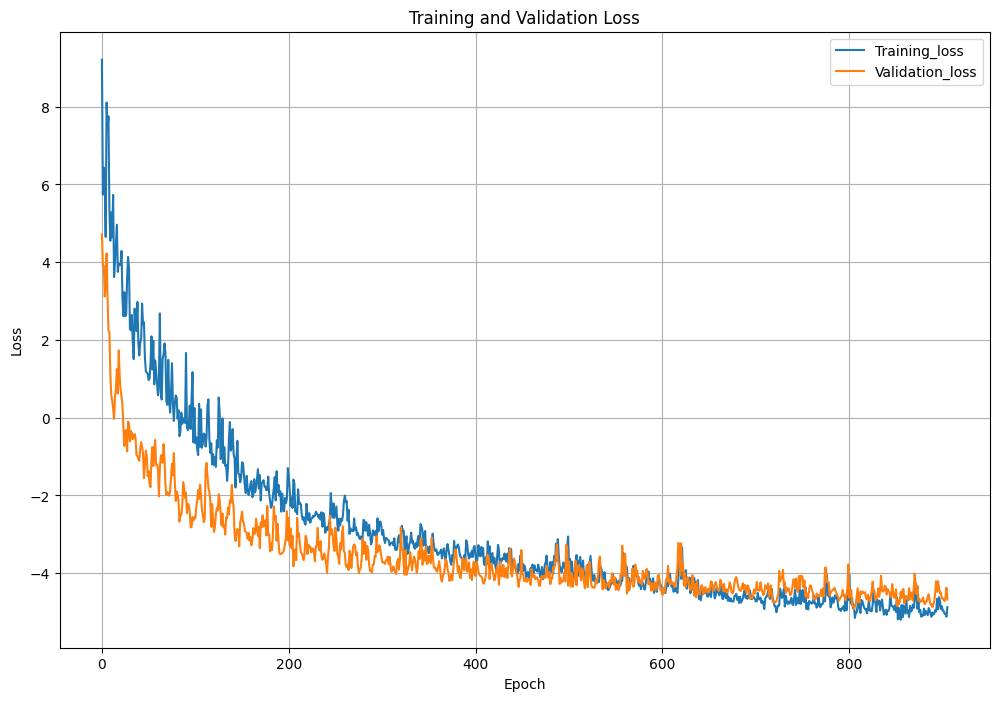

In [40]:
# Loss Plot

plot_loss(df1_history)#, logy=True, ylim=[15, 25])

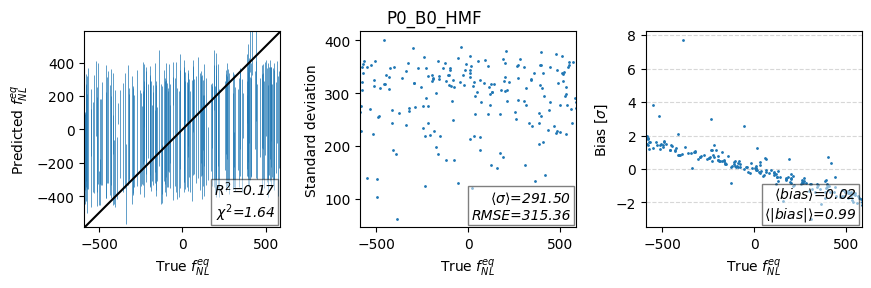

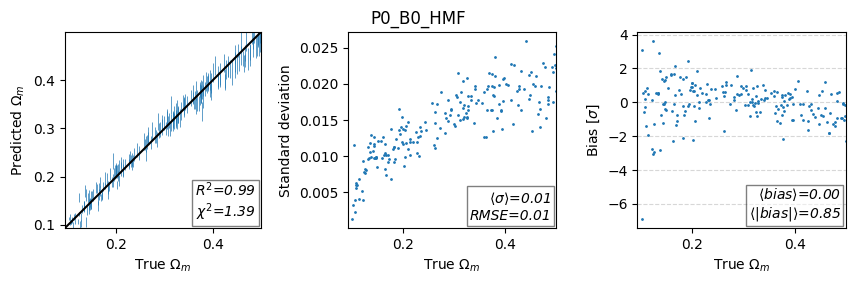

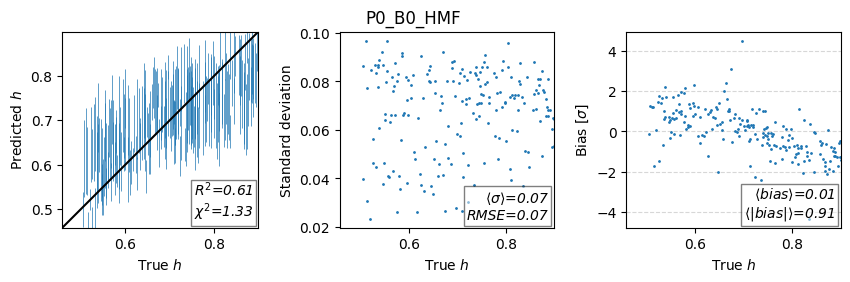

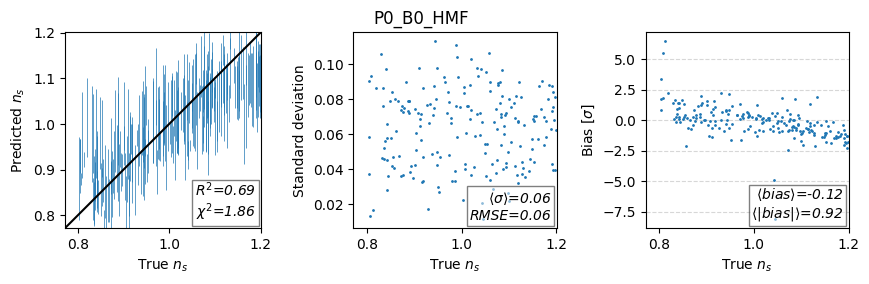

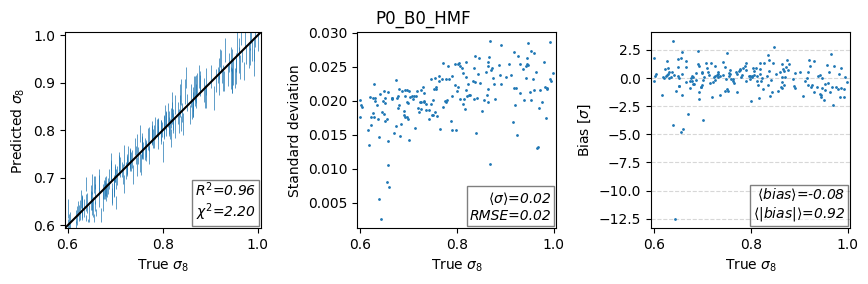

In [41]:
predictions1 = prediction(model1,X1_test,y1_test,mean_params,std_params,title = "P0_B0_HMF")


### Power Spectrum and Bispectrum Only

In [42]:
# Call the Data
columns = [P0, B0]
df_2 = input_data(columns,norm_lbl)


In [43]:
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = train_val_test_split(df_2 ,random_state = 5)

In [44]:
X_training_set = X2_train
tuner2 = kt.BayesianOptimization(
    model_build,
    objective= 'val_loss',
    max_trials = 20,
    directory='keras_tuner_dir',
    project_name='BO_P0B0_2')
# Running the HyperParameter Search

tuner2.search(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100000, callbacks=callback())




Reloading Tuner from keras_tuner_dir/BO_P0B0_2/tuner0.json


In [45]:
best_hp2=tuner2.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp2.get('num_layers')
best_architecture = [best_hp2.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp2.get('learning_rate')
best_dropout_rate = best_hp2.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")
print(tuner2.search_space_summary())
print(tuner2.results_summary())


Best Hyperparameters:
- Number of Layers: 3
- Architecture: [288, 320, 192]
- Learning Rate: 0.0001
- Dropout Rate: 0.1

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unit_num_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'samplin

In [46]:
# Fitting the model
model2 = model_build(best_hp1)
histories2= model2.fit(
    X2_train,
    y2_train,
    validation_data=(X2_val,
                     y2_val),
    batch_size=512,
    epochs=1000000,
    callbacks=callback(),
    verbose=0,
)
# Histories return 
df2_history = pd.DataFrame(histories2.history)
df2_history

,loss,val_loss
0,6.369228,4.325075
1,6.065258,4.585738
2,5.432707,4.134018
3,5.128307,3.062025
4,4.394233,4.065872
...,...,...
1607,-4.132417,-3.974999
1608,-4.075875,-3.934096
1609,-3.997659,-4.107899
1610,-4.226319,-3.842145


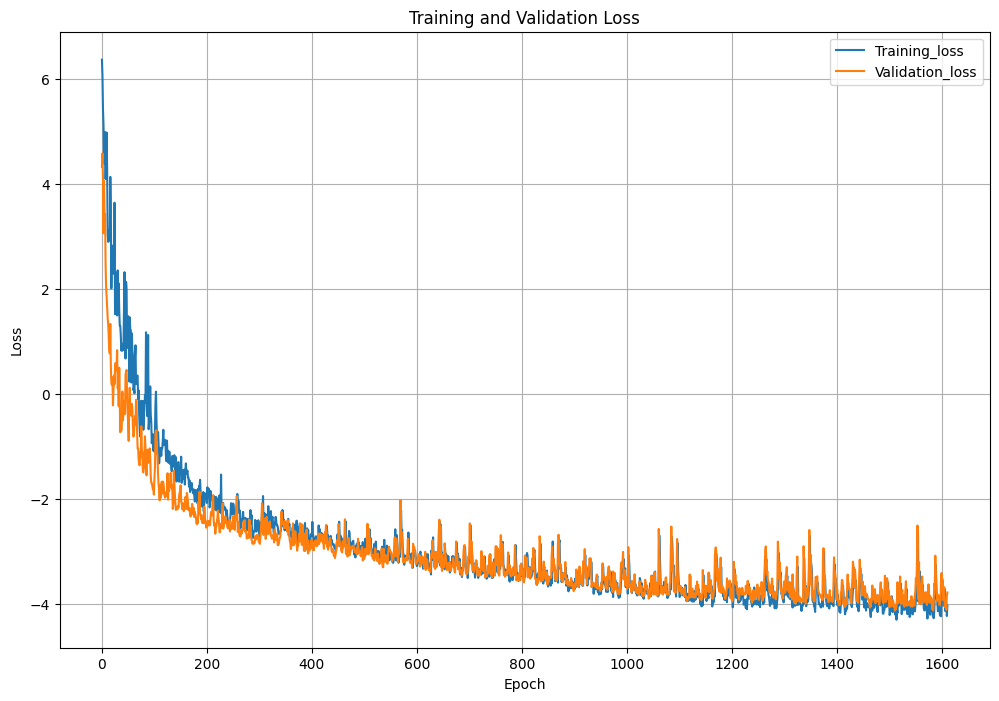

In [47]:
# Loss Plot
plot_loss(df2_history)#, logy=True, ylim=[15, 25])

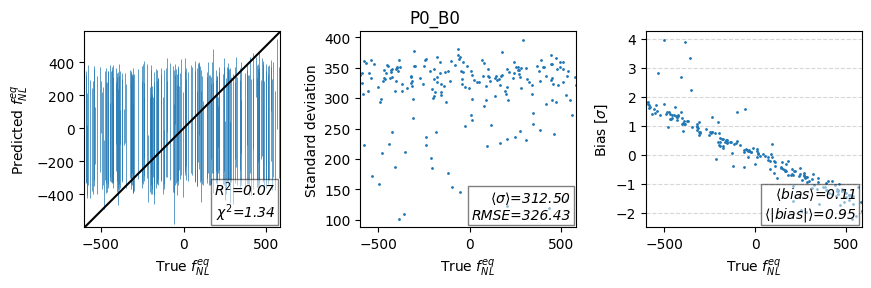

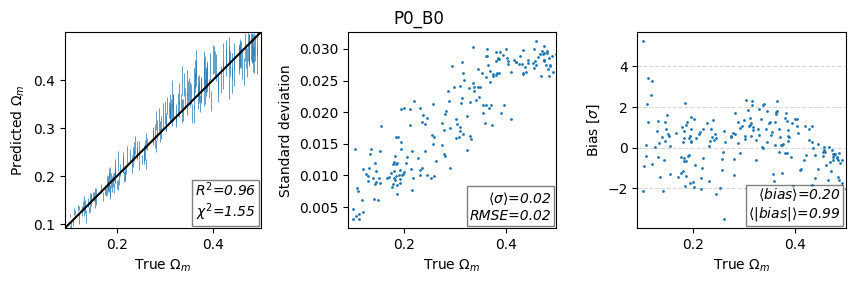

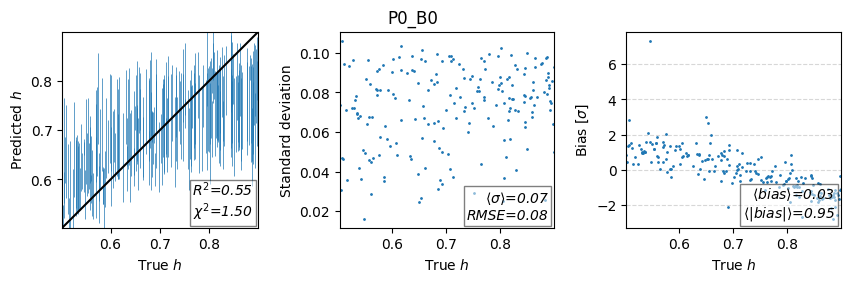

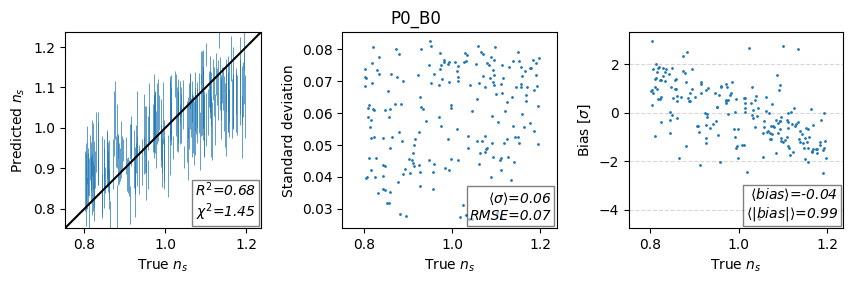

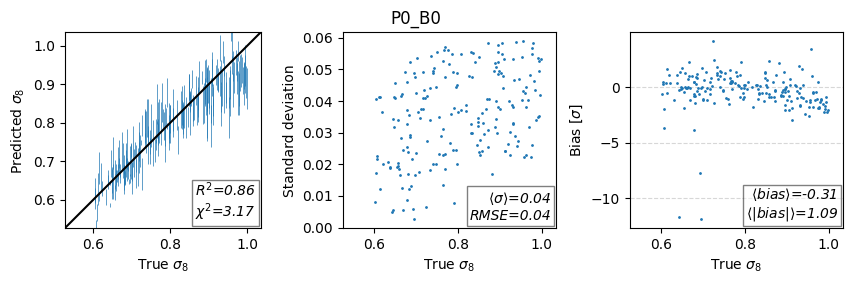

In [48]:
predictions2 = prediction(model2,X2_test,y2_test,mean_params,std_params,title = "P0_B0")


### P0, B0,MP0_0,MB0,HMF

In [20]:
columns = [P0, B0,MP0_0,MB0,HMF]
df_3 = input_data(columns,norm_lbl)


In [21]:
X3_train, X3_val, X3_test, y3_train, y3_val, y3_test = train_val_test_split(df_3 ,random_state = 42)

In [22]:
X_training_set = X3_train

tuner3 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='keras_tuner_dir',
    project_name ='P0, B0,MP0_0,MB0,HMF with clr all tuning 2',
    )
#'P0_B0_MP0_MB0_HMF_1012_with_clr_var_optlr&clr')

# Running the HyperParameter Search

tuner3.search(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=100000, callbacks= callback_early_stopping())




Trial 100 Complete [00h 03m 39s]
val_loss: -6.659058094024658

Best val_loss So Far: -7.299973011016846
Total elapsed time: 04h 08m 18s


In [23]:
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp3.get('num_layers')
best_architecture = [best_hp3.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp3.get('learning_rate')
best_dropout_rate = best_hp3.get('dropout_rate')
best_base_learning_rate = best_hp3.get('learning_rate')
best_batch_size = best_hp3.get('batch_size')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
""")
# - Number of Layers: {best_num_layers}
# - Architecture: {best_architecture}
# -Base Learning Rate (CLR): {best_base_learning_rate}
# - Opt_Learning Rate: {best_learning_rate}
#- Dropout Rate: {best_dropout_rate}
print(tuner3.search_space_summary())
print(tuner3.results_summary())



Best Hyperparameters:
- Number of Layers: 3
- Architecture: [64, 736, 128]
- Opt_Learning Rate: 0.0020014952656379117
- Base Learning Rate (CLR): 0.0020014952656379117
- Dropout Rate: 0.1000275722133798
- Batch Size: 16

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
unit_num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
unit_num_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
unit_num_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampl

In [134]:
# best_model = tuner3.get_best_models()[0]
# best_model.summary()

In [24]:
# Fitting the model
hypermodel3 = hp_model_for_dataset()
best_model3 = hypermodel3.build(best_hp3)
histories3= hypermodel3.fit(best_hp3,best_model3,
    X3_train,
    y3_train,
    validation_data=(X3_val,
                     y3_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df3_history = pd.DataFrame(histories3.history)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 312)]                0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 312)                  625       ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 dense_5 (Dense)             (None, 64)                   20032     ['normalization_1[0][0]']     
                                                                                                  
 dropout_3 (Dropout)         (None, 64)                   0         ['dense_5[0][0]']       

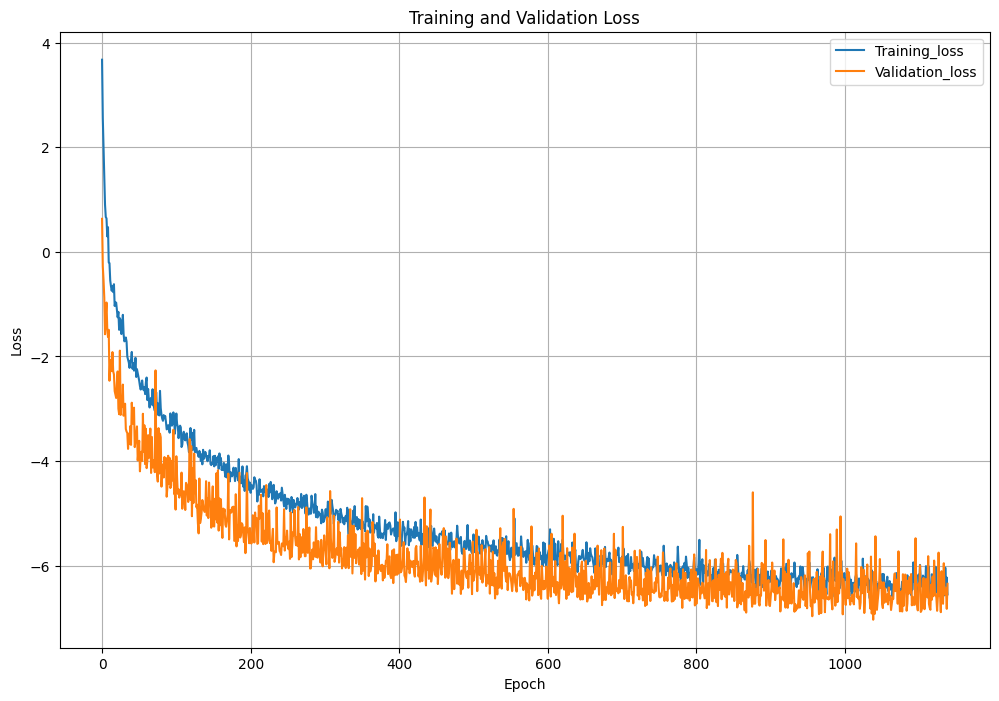

,loss,val_loss
0,3.672230,0.630832
1,2.556675,-0.278251
2,1.958713,-0.535869
3,1.438217,-0.878083
4,0.901814,-1.574817
...,...,...
1134,-6.566036,-6.539434
1135,-6.036320,-6.553307
1136,-6.370039,-6.432742
1137,-6.225523,-6.823613


In [25]:
# Loss Plot
plot_loss(df3_history)#, logy=True, ylim=[15, 25])
df3_history

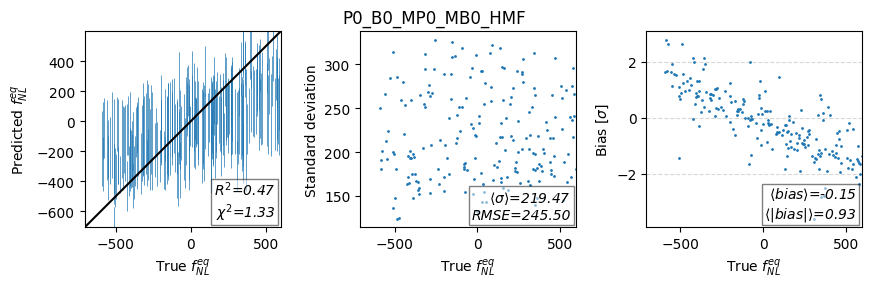

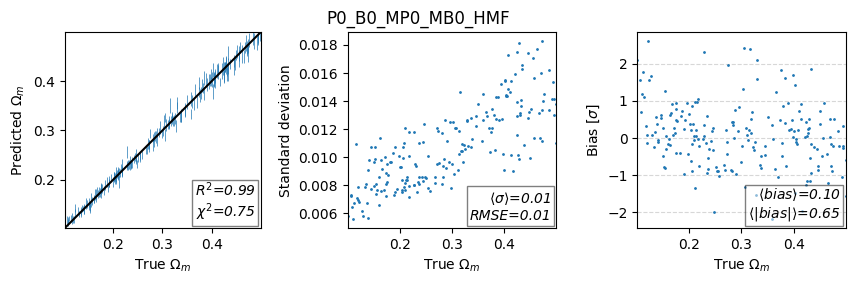

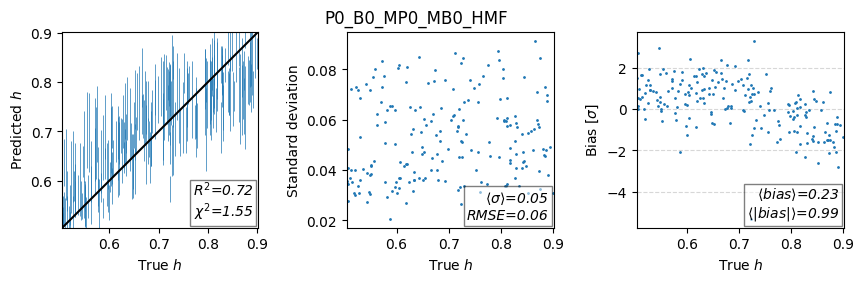

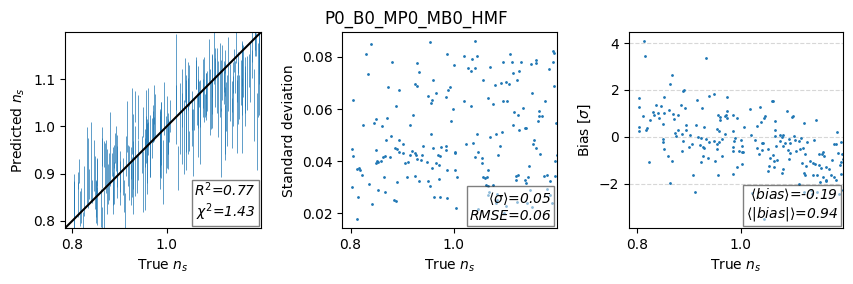

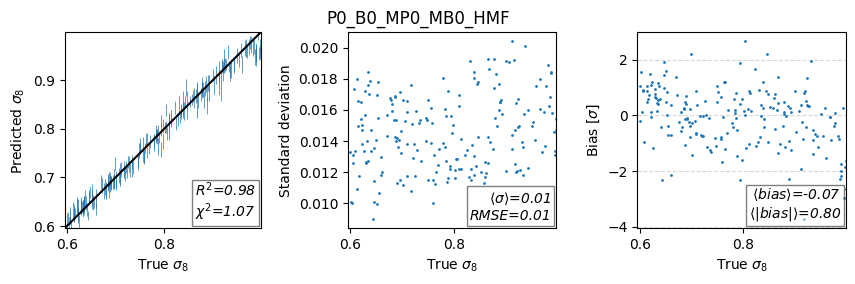

In [26]:
predictions3 = prediction(best_model3,X3_test,y3_test,mean_params,std_params,title = "P0_B0_MP0_MB0_HMF")


## PARAM vs LOSS plot

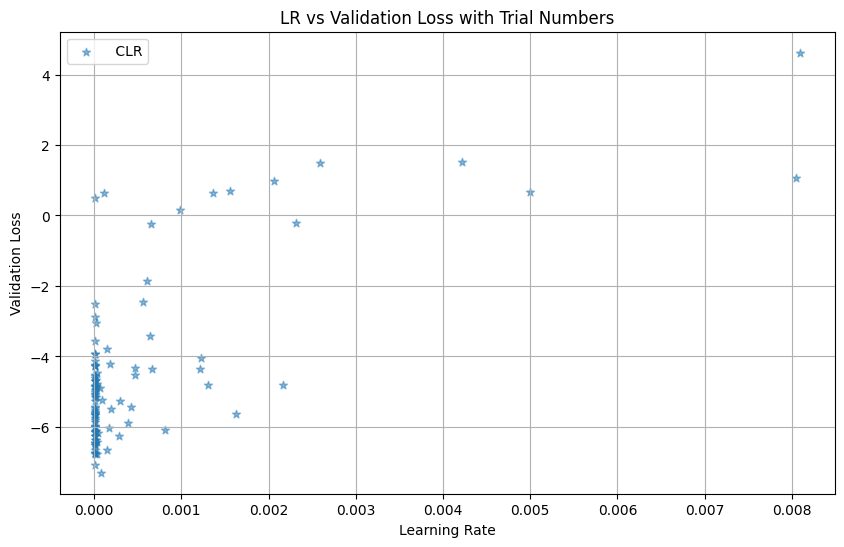

In [27]:
# Extracting dropout rates, trial numbers, and corresponding validation losses from tuner results
# dropout_rates = []
learning_rates = []
base_learning_rates = []
validation_losses = []
trial_numbers = []
dropout_rates = []
for trial_number, trial in tuner3.oracle.trials.items():
    base_learning_rate = trial.hyperparameters.values['base_learning_rate']
    learning_rate = trial.hyperparameters.values['learning_rate']
    droput_rate = trial.hyperparameters.values['dropout_rate']
    val_loss = trial.metrics.get_last_value('val_loss')
    learning_rates.append(learning_rate)
    base_learning_rates.append(base_learning_rate)
    dropout_rates.append(droput_rate)
    validation_losses.append(val_loss)
    trial_numbers.append(trial_number)
    
# print(len(validation_losses))
# print(len(base_learning_rates))
# print(len(learning_rates))
# Plotting the base learning rate vs validation loss with trial numbers as annotations
plt.figure(figsize=(10, 6))
# plt.scatter(learning_rates, validation_losses, marker='o', label='OPT_lr', alpha=0.5)
plt.scatter(base_learning_rates, validation_losses, marker='*', label=' CLR', alpha=0.5)
# plt.scatter(dropout_rates, validation_losses, marker='+', label='OPT_lr', alpha=0.5)
#####################################################################################################################################
# Adding trial numbers as annotations with adjusted placement
# for i, txt in enumerate(trial_numbers):
#     plt.annotate(txt, (base_learning_rates[i], validation_losses[i]), textcoords="offset points", xytext=(0, 8), ha='center')

# min_loss_index = validation_losses.index(min(validation_losses))
# plt.annotate(f"{trial_numbers[min_loss_index]}",(learning_rates[min_loss_index],validation_losses[min_loss_index]), 
#              textcoords="offset points", xytext=(0, 8), ha='center')

# plt.annotate(f"{trial_numbers[min_loss_index]}",(base_learning_rates[min_loss_index],validation_losses[min_loss_index]), 
#              textcoords="offset points", xytext=(0, 8), ha='center')

######################################################################################################################################

plt.title('LR vs Validation Loss with Trial Numbers')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.legend()
# plt.xlim(1e-5,2e-5)
plt.grid(True)
# plt.savefig("all_lr_clr_1.png")
# Display the plot
plt.show()


Are both the opt_learning_rate and the Cyclic Learning Rate (CLR) are used simultaneously to adjust the learning rate during training? Maybe The opt_learning_rate is used as the starting point for the CLR, and the CLR modulates the learning rate dynamically based on the progress of training.
Maybe this approach is allowing for a more fine-grained and adaptive adjustment of the learning rate?, potentially leading to better convergence and performance?can i show it from the plots.

Maybe this is gow it is used together:

The opt_learning_rate is set during model construction, and it serves as the initial learning rate for the optimizer.

During training, the CLR scheduler takes over and modifies the lr according to its cyclical lr pattern.

The modified lr, based on the CLR, is then used for the optimizer's updates.


Is the clr lr and batch rate being tuned independently of the other hyper parameters?


In [156]:
tf.keras.callbacks
# print(clr_triangular.history.keys())

# # Plot the learning rates
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'][:1000], clr_triangular.history['lr'][:1000])
# # plt.plot(clr_triangular.history['lr'][:1000], clr_triangular.history['loss'][:1000])

# plt.show()


<module 'tensorflow.keras.callbacks' from '/home/ubuntu/miniconda3/envs/tf/lib/python3.11/site-packages/keras/api/_v2/keras/callbacks/__init__.py'>

In [33]:
print(callback()[0])

In [41]:
clr_triangular = CyclicLR(#mode='exp_range',
                                  base_lr=max_lr/4.,
                                  max_lr=max_lr,
                                  step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                                  gamma=0.99994)
clr_triangular
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
        restore_best_weights=True,
        verbose=1)
early_stopping

In [42]:
callback()

In [85]:
hp_base_learning_rate = best_hp3.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")
'base_learning_rate'

'base_learning_rate'